In [1]:
import torch
import numpy as np
from IPython import display
from matplotlib import pyplot as plt
import random
print(torch.__version__)
torch.set_default_tensor_type('torch.FloatTensor')

1.2.0


## 生成数据集

In [2]:
num_inputs = 2
num_examples = 1000
true_w = [2,-3.4]
true_b = 4.2
features = torch.randn(num_examples,num_inputs)  #randn标准正态分布
labels = true_w[0]*features[:,0] + true_w[1]*features[:,1] + true_b
labels += torch.tensor(np.random.normal(0,1,size=labels.size()),dtype=torch.float)  
#噪声调为1的情况也可以得到近似的结果
#np.random.normal 生成正态分布的随机数

## 显示数据

torch.Size([1000, 2]) torch.Size([1000])
1000


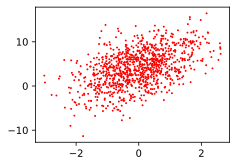

In [3]:
display.set_matplotlib_formats('svg') #用矢量图显示
plt.rcParams['figure.figsize'] = (3.5,2.5)  #可以不设置
plt.scatter(features[:,0],labels,1,'r')   #s=1,c='r' size和color，顺序可以不写，为清楚应该表面是哪个参数
print(features.size(),labels.size())
print(len(features))

## 读取数据

In [4]:
def data_iter(batch_size,features,labels):
    num_examples = len(features)  #torch len
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0,num_examples,batch_size):
        j = torch.LongTensor(indices[i:min(i+batch_size,num_examples)])  #Long 64bit整数 
        #正常就是[i:i+batch_size],最后一组可能不足一个batch
        yield features.index_select(0,j),labels.index_select(0,j)

In [5]:
batch_size = 10
for X,y in data_iter(batch_size,features,labels):
    print(X,'\n',y)
    break  #所以只打印一次

tensor([[-0.3601, -1.0011],
        [-0.3566,  0.9398],
        [-0.5493,  0.0723],
        [-0.6516, -0.7366],
        [-1.3988, -0.5209],
        [-0.1294, -0.7080],
        [ 0.2289,  0.9641],
        [ 0.4601, -0.3662],
        [ 1.2904,  1.6709],
        [-1.7762,  3.0735]]) 
 tensor([  5.5454,   0.6299,   2.2403,   4.6122,   2.4267,   4.3316,  -0.0452,
          4.6962,   0.3612, -11.3400])


## 初始化模型参数

In [6]:
w = torch.tensor(np.random.normal(0,0.01,(num_inputs,1)),dtype=torch.float)
b = torch.zeros(1)
print(w,b)
print(w.data)
print(w.mean())

tensor([[-0.0053],
        [ 0.0089]]) tensor([0.])
tensor([[-0.0053],
        [ 0.0089]])
tensor(0.0018)


In [7]:
w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True)

tensor([0.], requires_grad=True)

## 定义模型 损失函数 优化函数

In [8]:
def linreg(X,w,b):
    return torch.mm(X,w) +b  #b会广播相加

def squared_loss(y_hat,y):
    #rint(y_hat.size(),y.size())
    return (y_hat-y.view(y_hat.size()))**2/2
    #return(y_hat-y)**2 /2  #这个会有问题y_hat[10,1],y[10]

def sgd(params,lr,batch_size):
    for param in params:
        param.data -=lr*param.grad/batch_size

## 训练模型

In [9]:
lr = 0.03
num_epochs =3

for epoch in range(num_epochs):
    for X,y in data_iter(batch_size,features,labels): 
        l = squared_loss(linreg(X,w,b),y).sum()
        l.backward()
        sgd([w,b],lr,batch_size)
        
        w.grad.data.zero_()
        b.grad.data.zero_()
    train_l = squared_loss(linreg(features,w,b),labels)
    print('epoch %d, loss %f' %(epoch+1, train_l.mean().item()))  #mean() 平均值tensor，item()是一个值

epoch 1, loss 0.542973
epoch 2, loss 0.501996
epoch 3, loss 0.502236


In [10]:
print(true_w,'\n',w)
print(true_b,'\n',b)

[2, -3.4] 
 tensor([[ 1.9798],
        [-3.4322]], requires_grad=True)
4.2 
 tensor([4.1360], requires_grad=True)


#### grad机制还不熟，sum()是必须的，grad只能应用在单个数字输出